<h1> Introdução </h1>

<p> O tema selecionado para análise foi a <b>Avaliação de Risco de Crédito</b> por sua relevância no mercado econômico e financeiro bem como por sua complexidade, fomentando a aplicação comparativa de diversas técnicas de análises preditivas </p>

<h3> Fonte de Dados </h3>
<p> A base de dados utilizada neste estudo foi obtida no site de competições em ciência de dados kaggle.com, <a href=https://www.kaggle.com/wendykan/lending-club-loan-data/home>Lending Club Load Data </a> e consiste em um conjunto de dados completo de empréstimos concedidos a clientes entre 2007-2015, incluindo o status atual do empréstimo (calculado até à data de publicação do dataset). 
<br>Os recursos adicionais incluem pontuação de crédito, número de consultas financeiras, endereço entre outros. O arquivo é uma tabela de cerca de 890 mil observações e 75 variáveis. Um dicionário de dados (table metadata) é fornecido em um arquivo separado </p>

<h3>Objetivo</h3>
<p>Contruir um modelo que preveja se um pedido de empréstimo será honrado (loan_status="Fully Paid" ou "Current") ou não (loan_status="Demais valores")</p>

<h3>Metodologia</h3>
<p>A metodologia de análise será composta das seguintes etapas</p>
<ol>
    <li>Avaliação Preliminar</li>
    <li>Análise Descritiva</li>
    <li>Análise Bivariada</li>
    <li>Treinamento do modelo: <b>Regressão Logística</b></li>
    <li>Treinamento do modelo: <b>Árvore de Decisão</b></li>
    <li>Comparação de Performance</li>
    <li>Conclusão</li>
</ol>



<h2>1 - Avaliação Preliminar</h2>
<ul>
    <li>Leitura da base de dados</li>
    <li>Validação do tamanho da base</li>
    <li>Compreensão das variáveis disponíveis</li>
    <li>Quantificação dos valores faltantes (missing values)</li>
    <li>Identificação da variávei alvo <b>(target)</b></li>
</ul>


<h3>Leitura da base de dados</h3>

In [57]:
#importing python data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

#configuring appearence styles
sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

In [58]:
raw_data = pd.read_csv('../loan.csv',low_memory=False)

<h4>Visualização do tamanho e dimensões da base </h4>

In [142]:
def print_shape(dataframe):
    shape = dataframe.shape
    print("As dimensões da base são: \n\n \
            Quantidade de Observações: {} \n \
            Quantidade de Variáveis  : {}".format(shape[0],shape[1]))
    
print_shape(raw_data)

As dimensões da base são: 

             Quantidade de Observações: 887379 
             Quantidade de Variáveis  : 74


<h4> Retira uma amostra aleatória do Dataset para reduzir consumo de memória </h4>
<p>O tamanho da amostra corresponde a 25% do tamanho original do dataset</p>

In [195]:
df = raw_data.sample(frac=.25).copy()
print_shape(df)

As dimensões da base são: 

             Quantidade de Observações: 221845 
             Quantidade de Variáveis  : 74


<h4>Visualização dos nomes e metadados das colunas para compreensão das variáveis disponíveis</h4> 
<p>Neste ponto, o arquivo de metadados disponibilizado pelo kaggle é utilizado para compreender o significado de cada variável existente no dataset </p>

In [196]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [197]:
df_metadata = pd.read_excel(io='../LCDataDictionary.xlsx').dropna()
df_metadata.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


<h4> Quantificação dos valores faltantes (missing)</h4>

In [198]:
#Definição de função de avaliação quantitativa de valores ausentes em um dado Pandas.DataFrame
def missing_values(dataframe):
        mis_val = dataframe.isnull().sum()
        mis_val_percent = 100 * (dataframe.isnull().sum() / len(dataframe))
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'}
        )
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0
        ].sort_values(
            '% of Total Values', ascending=False
        ).round(1)
        
        qtd_columns_over_limit = len(mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values']>50.0])
        
        print("O Dataset possui " + str(df.shape[1]) + " colunas.\n"
                + str(mis_val_table_ren_columns.shape[0]) + 
                " Colunas possuem valores ausentes. \n" 
                + str(qtd_columns_over_limit) +
                " Colunas cuja proporção de valores ausentes ultrapassa 50% das observações")
        
        return mis_val_table_ren_columns
    
#Quantifica os valores faltantes no dataset estudado    
missing_statistics = missing_values(df)
missing_statistics[missing_statistics['% of Total Values']>50.0]

O Dataset possui 74 colunas.
39 Colunas possuem valores ausentes. 
21 Colunas cuja proporção de valores ausentes ultrapassa 50% das observações


,Missing Values,% of Total Values
dti_joint,221721,99.9
annual_inc_joint,221721,99.9
verification_status_joint,221721,99.9
il_util,217210,97.9
mths_since_rcnt_il,216645,97.7
total_cu_tl,216497,97.6
inq_fi,216497,97.6
all_util,216497,97.6
max_bal_bc,216497,97.6
open_rv_24m,216497,97.6


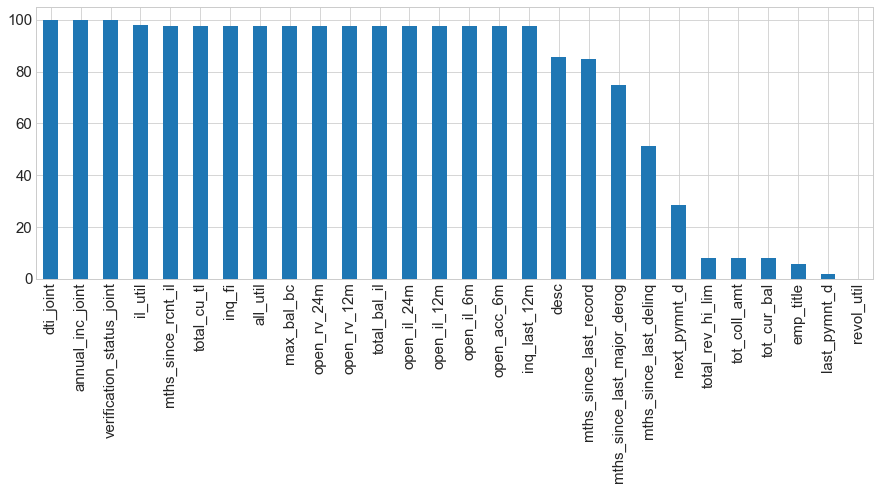

In [199]:
plt.Figure(figsize=(15,5))
missing_statistics[
                   missing_statistics['% of Total Values'] > 0.0
                  ]['% of Total Values'].plot(
                        kind='bar',
                        figsize=(15,5),
                        fontsize=15
                    )
plt.show()

<p> O gráfico acima mostra que a base de dados possui algumas colunas com um percentual muito alto de observações nulas ou faltantes (acima de 75%, exemplos: `dti_joint`,`annual_inc_joint`,`verification_status_joint`) e que deverão ser tratadas/removidas para a modelagem</p>

In [200]:
#exclusão de colunas com mais de 50% de valores ausentes (missing)
df.drop(labels=missing_statistics[missing_statistics['% of Total Values'] > 50.0].index,
        axis=1,
        inplace=True)
print_shape(df)

As dimensões da base são: 

             Quantidade de Observações: 221845 
             Quantidade de Variáveis  : 53


<h4> Identificação da variávei alvo (target)</h4>
<p>A coluna que contém a variável alvo do estudo é a <b>Loan Status</b>. Esta variável representa a situação corrente do título de empréstimo no momento da publicação do dataset (Current, Late, Fully Paid, etc...).</p>

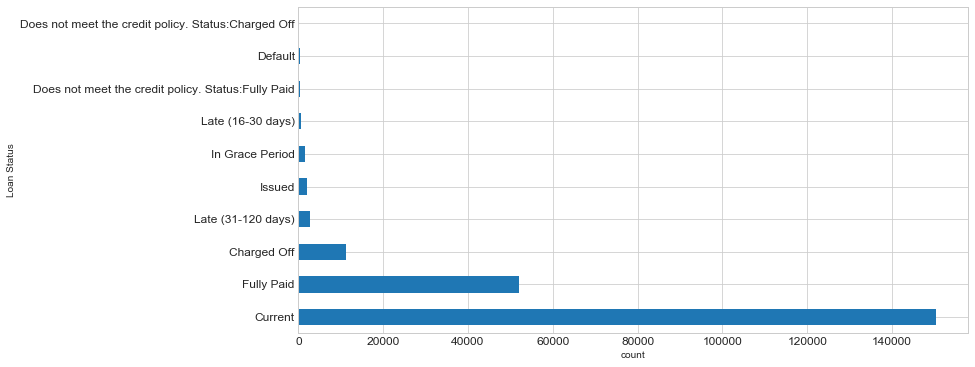

In [201]:
plt.figure(figsize=(12,6))
plt.ylabel('Loan Status')
plt.xlabel('count')
df['loan_status'].value_counts().plot(kind='barh',grid=True,fontsize=12)
plt.show()

Taxa de Bons Empréstimos: 91.27%
Taxa de Maus Empréstimos: 8.73%


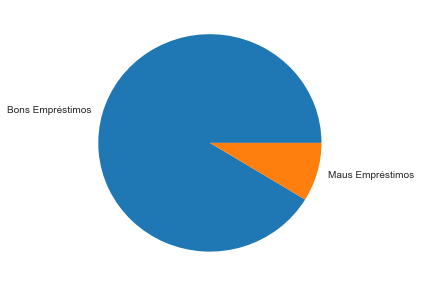

In [202]:
#Calcula proporção de empréstimos "Bons" e "Maus"
good_loan = len(df[(df.loan_status=='Fully Paid') |
                   (df.loan_status=='Current')])

good_loan_ratio = good_loan/len(df)
bad_loan_ratio = 1-good_loan_ratio

print("Taxa de Bons Empréstimos: %.2f%%" % (good_loan_ratio*100))
print("Taxa de Maus Empréstimos: %.2f%%" % (bad_loan_ratio*100))

pie_target_ratio = pd.Series({
    "Bons Empréstimos":(good_loan_ratio*100),
    "Maus Empréstimos":(bad_loan_ratio*100)
})

plt.figure(figsize=(5,5))
plt.pie(x=pie_target_ratio,labels=pie_target_ratio.index)
plt.show()

<h4>Observação</h4>
<p>A proporção acima mostra claramente que se trata de um caso em que a classe alvo está desbalanceada. Isto significa que uma determinada classe de observações da variável alvo (loan_status) apresenta uma proporção muito superior superior do que as demais na base e acaba dominando o modelo.</p>
<p> Esta característica deverá ser tratada ao longo do estudo, utilizando técnicas apropriadas </p>

In [203]:
#Define a variável target (alvo)
## 1 = Empréstimo Honrado ("Fully Paid" ou "Current")
## 0 = Empréstimo Não Honrado (Demais Categorias)
df['target'] = df['loan_status'].apply(lambda value: 1 if value in ("Fully Paid","Current") else 0)
df.drop('loan_status',axis=1,inplace=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
598582,60801386,64853140,12000.0,12000.0,11900.0,36 months,9.99,387.15,B,B3,...,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,146885.0,12800.0,1
577208,61404082,65522956,12000.0,12000.0,12000.0,36 months,9.99,387.15,B,B3,...,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,28199.0,32700.0,1
569194,62286432,66483186,8725.0,8725.0,8700.0,36 months,17.57,313.56,D,D4,...,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,326.0,30252.0,14100.0,1
809000,43429773,46456506,35000.0,35000.0,35000.0,36 months,6.92,1079.42,A,A4,...,NaN,Nov-2015,0.0,1.0,INDIVIDUAL,0.0,0.0,63191.0,171000.0,1
198956,1493671,1753733,35000.0,35000.0,35000.0,60 months,24.70,1021.15,G,G1,...,NaN,Jul-2015,0.0,1.0,INDIVIDUAL,0.0,0.0,263088.0,25241.0,1


<h2>2 - Análise Descritiva</h2>
<ul>
    <li>Medidas de Centralidade/Variabilidade (variáveis numéricas)</li>
    <li>Medidas de Frequência/Classes Distintas (variáveis categóricas)</li>
</ul>


<h4>Avaliação dos tipos de variáveis (Numéricas/Categóricas)</h4>
<p>Por definição (pandas.DataFrame), as variáveis numéricas no Dataset são classificadas como `float64` ou `int64`, enquanto as categóricas são classificadas como `object`</p>

As dimensões da base são: 

             Quantidade de Observações: 221845 
             Quantidade de Variáveis  : 53


Quantidade de cada Tipo de Dados existente na base 

float64    30
object     20
int64       3
dtype: int64


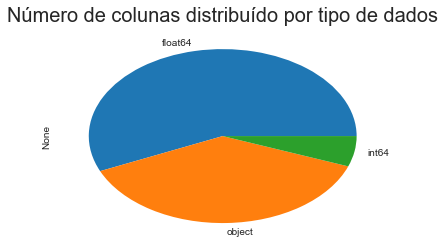

In [204]:
# Quantidade de tipos de dados diferentes no dataset
print_shape(df)
print("\n")
print("Quantidade de cada Tipo de Dados existente na base \n")
print(df.dtypes.value_counts())
df.dtypes.value_counts().plot(kind='pie')
plt.title('Número de colunas distribuído por tipo de dados',fontsize=20)
#plt.xlabel('Número de colunas',fontsize=15)
#plt.ylabel(None)

<p>O gráfico acima nos mostra que temos uma quantidade considerável de colunas com valores do tipo `object` (variáveis categóricas) que deverão ser tratadas e/ou removidas para uso no modelo </p>

<h4>Avaliação das variáveis categóricas</h4>
<p>Quantificação e frequência das classes únicas existentes em cada variável categórica do dataset</p>

Variáveis categóricas e ocorrências distintas pela base 

                     qtd_unicos  perc_unicos
url                      221845   100.000000
emp_title                 94086    42.410692
title                     19345     8.720052
zip_code                    896     0.403886
earliest_cr_line            644     0.290293
issue_d                     103     0.046429
last_pymnt_d                 97     0.043724
last_credit_pull_d           97     0.043724
next_pymnt_d                 87     0.039217
addr_state                   51     0.022989
sub_grade                    35     0.015777
purpose                      14     0.006311
emp_length                   12     0.005409
grade                         7     0.003155
home_ownership                6     0.002705
verification_status           3     0.001352
term                          2     0.000902
initial_list_status           2     0.000902
application_type              2     0.000902
pymnt_plan                    1     0.0004

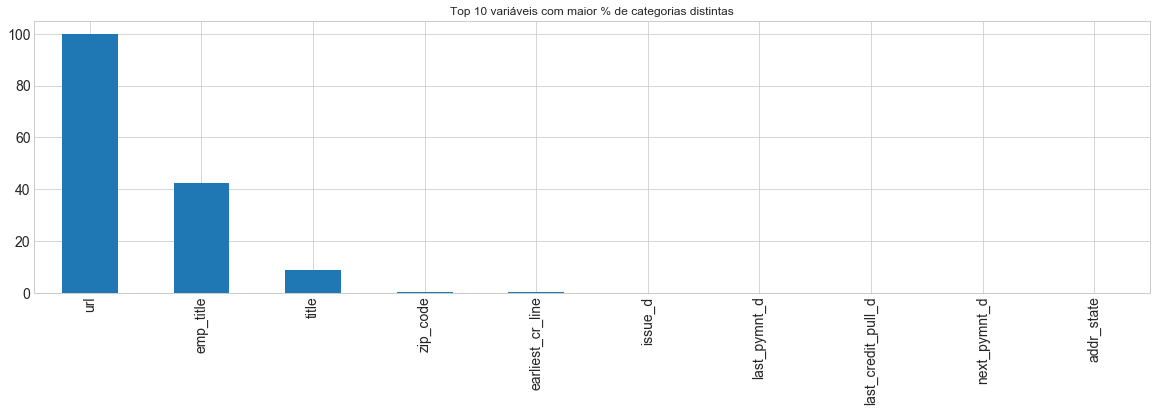

In [206]:
category = pd.DataFrame({ 'qtd_unicos': df.select_dtypes(include=['object']).apply(pd.Series.nunique, axis = 0)})  
category['perc_unicos'] = category['qtd_unicos'].apply(lambda x: (float(x)/len(df))*100)

print("Variáveis categóricas e ocorrências distintas pela base \n")
print(category.sort_values(by='perc_unicos',ascending=False))

#plota o gráfico de barras por percentual de categorias únicas
category['perc_unicos'].sort_values(ascending=False).head(10).plot.bar(
    figsize=(20,5),
    fontsize=14,
    title='Top 10 variáveis com maior % de categorias distintas')

<p> O gráfico acima nos mostra que algumas variáveis possuem alta variabilidade (número extremamente alto de categorias distintas). É o caso das variáveis `url`,`emp_title`,`title` e `title`. Estas variáveis possuem alto número de categorias distintas, o que indica aleatoriedade e prejudica a assertividade do modelo.<p>

<p> Estas variáveis serão desconsideradas na análise </p>

In [207]:
df.drop(['url','emp_title','title'],axis=1,inplace=True)
print_shape(df)

As dimensões da base são: 

             Quantidade de Observações: 221845 
             Quantidade de Variáveis  : 50


In [209]:

df.select_dtypes(include=['object']).describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,221845,221845,221845,221845,221845,221845,221845,221845,221845,221845,221845,221836,221845,217359,158400,221829,221845
unique,2,7,35,12,6,3,103,1,14,896,51,644,2,97,87,97,2
top,36 months,B,B3,10+ years,MORTGAGE,Source Verified,Oct-2015,n,debt_consolidation,945xx,CA,Aug-2001,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
freq,154996,63764,14074,72894,111020,82497,11997,221845,131223,2472,32518,1622,114325,117417,138228,182519,221721
